## Three-dimensional yield curve

In [ ]:
## Three-level stratification thresholds
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Database name mapping and corresponding thresholds
db_mapping = {
    
    'H1': {'db': 'GDPH', 'thr1': 0.090, 'thr2': 0.820, 'max_density': 0.06},  # Relative net benefit is positive
    'H2': {'db': 'SZBA', 'thr1': 0.100, 'thr2': 0.790, 'max_density': 0.06},  # Relative net benefit is positive
    'H3': {'db': 'MIMIC', 'thr1': 0.090, 'thr2': 0.750, 'max_density': 0.08},  # Relative net benefit is positive

   }

# List of database names
db_names = ['H1', 'H2', 'H3']

# Modify data paths
cd = r'./'
cd2 = r'./7-SZBA_prospective/' 

db_name = 'H2'  # Select database name (change to one of H1, H2, H3)

db_info = db_mapping[db_name]  # Get the corresponding database information
db = db_info['db']  # Database name
thr1 = db_info['thr1']  # Corresponding threshold 1
thr2 = db_info['thr2']  # Corresponding threshold 2
max_density = db_info['max_density']  # Corresponding maximum density value

if db_name == 'H2':
    search_path1 = cd2 + '7.5-final_model/' + db + '/'  # Model results
else:
    search_path1 = cd + '5-final_model/' + db + '/'  # Model results

pred_result = pd.read_csv(search_path1 + 'predict_5CV/alldata/predict_result.csv')


In [ ]:
################# Iterate over the threshold grid, calculate net benefit, and save as CSV #################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

y = pred_result['y_test'].values  # True labels
p = pred_result['y_tepred'].values  # Predicted probabilities
N = len(pred_result)  # Number of samples

# Parameter settings
B1 = 1.0
alpha = 0.6
beta = 0.1

# Threshold grid
# k1_vals = np.concatenate([np.linspace(0.01, 0.25, 50), np.linspace(0.26, 0.90, 50), np.linspace(0.91, 1.0, 5)])  # Low-risk threshold
# k2_vals = np.concatenate([np.linspace(0.01, 0.25, 50), np.linspace(0.26, 0.90, 50), np.linspace(0.91, 1.0, 5)])  # High-risk threshold
k1_vals = np.arange(0, 0.2, 0.01)  # Low-risk threshold
k2_vals = np.arange(0.2, 1.01, 0.01)  # High-risk threshold
K1, K2 = np.meshgrid(k1_vals, k2_vals)

Z = np.full_like(K1, np.nan)  # Main surface for plotting
Z_diag_vals = []              # Values along diagonal (k1 = k2)
diag_k1, diag_k2 = [], []     # Diagonal coordinates

# Grid computation
for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        k1 = K1[i, j]
        k2 = K2[i, j]

        # if k1 < 0.05:
        #     Z[i, j] = np.nan
        #     continue

        if k1 > k2:
            continue
        elif np.isclose(k1, k2, atol=1e-6):
            # === Binary classification case ===
            k = k1
            treat_mask = p >= k
            TP = np.sum((y == 1) & treat_mask)
            FP = np.sum((y == 0) & treat_mask)
            prevalence = np.mean(y)
            C = k / (1 - k)

            nb_model = (TP / N) - (FP / N) * C
            nb_all = prevalence - (1 - prevalence) * C
            nb_none = 0
            relative_nb = nb_model - max(nb_all, nb_none)

            Z[i, j] = np.nan  # Do not plot diagonal on main surface
            diag_k1.append(k1)
            diag_k2.append(k2)
            Z_diag_vals.append(relative_nb)
            continue

        # === Three-class net benefit calculation ===
        C1 = k2 / (1 - k2)
        L1 = (1 - k1) / k1
        C2 = beta * C1
        B2 = alpha * B1

        low_mask = p < k1
        mid_mask = (p >= k1) & (p <= k2)
        high_mask = p > k2

        net_benefit = 0
        net_benefit += np.sum((y == 1) & high_mask) * B1
        net_benefit += np.sum((y == 1) & mid_mask) * B2
        net_benefit -= np.sum((y == 1) & low_mask) * L1
        net_benefit -= np.sum((y == 0) & high_mask) * C1
        net_benefit -= np.sum((y == 0) & mid_mask) * C2
        net_benefit /= N

        prevalence = np.mean(y)
        nb_all = B1 * prevalence - C1 * (1 - prevalence)
        nb_none = -L1 * prevalence

        Z[i, j] = net_benefit - max(nb_all, nb_none)

# Collect all non-NaN k1, k2, z values
k1_list = []
k2_list = []
z_list = []

for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        if not np.isnan(Z[i, j]):
            k1_list.append(K1[i, j])
            k2_list.append(K2[i, j])
            z_list.append(Z[i, j])

df = pd.DataFrame({
    'k1': k1_list,
    'k2': k2_list,
    'z': z_list
})

print(df)
# df.to_excel(f'./{db_name}.xlsx')


        k1   k2             z
0     0.01  0.2  9.051809e-02
1     0.02  0.2  1.120538e-01
2     0.03  0.2  1.244761e-01
3     0.04  0.2  1.316691e-01
4     0.05  0.2  1.315302e-01
...    ...  ...           ...
1534  0.15  1.0 -1.418029e+15
1535  0.16  1.0 -1.419604e+15
1536  0.17  1.0 -1.420754e+15
1537  0.18  1.0 -1.422015e+15
1538  0.19  1.0 -1.422997e+15

[1539 rows x 3 columns]


In [ ]:
# ================== Extract only the region where z > 0 ==================
# df_pos = df[df['z'] > 0]

# print("Range of k1/k2 values where z > 0:")
# print(f"k1 min: {df_pos['k1'].min():.3f}, k1 max: {df_pos['k1'].max():.3f}")
# print(f"k2 min: {df_pos['k2'].min():.3f}, k2 max: {df_pos['k2'].max():.3f}")

import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

# Keep only rows where z > 0
df_pos = df[df['z'] > 0]

# If no points satisfy z > 0
if df_pos.empty:
    print("No (k1, k2) values yield z > 0")
else:
    # Extract all (k1, k2) coordinates
    points = df_pos[['k1', 'k2']].values
    
    # Compute the convex hull (strict boundary)
    hull = ConvexHull(points)
    
    # Get boundary vertex coordinates
    boundary_points = points[hull.vertices]

    # Print the polygon that strictly encloses all z > 0 points
    print("z is guaranteed to be > 0 when (k1, k2) lies inside the following polygon:")
    for x, y in boundary_points:
        print(f"    (k1={x:.3f}, k2={y:.3f})")

    # # Save the boundary points if needed
    # pd.DataFrame(boundary_points, columns=['k1','k2']).to_csv("z_positive_boundary.csv", index=False)


当 (k1, k2) 落在以下多边形区域内时，z 必定 > 0：
    (k1=0.010, k2=0.200)
    (k1=0.190, k2=0.200)
    (k1=0.190, k2=0.800)
    (k1=0.160, k2=0.840)
    (k1=0.150, k2=0.850)
    (k1=0.010, k2=0.970)


        k1    k2         z
0     0.02  0.04 -0.090584
1     0.02  0.06 -0.075565
2     0.04  0.06 -0.062389
3     0.02  0.08 -0.058472
4     0.04  0.08 -0.045041
...    ...   ...       ...
1171  0.88  0.98 -0.117755
1172  0.90  0.98 -0.113067
1173  0.92  0.98 -0.105808
1174  0.94  0.98 -0.098628
1175  0.96  0.98 -0.090077

[1176 rows x 3 columns]
alpha: 0.6 beta: 0.1
最高相对收益: 1.5369，对应k1=0.020, k2=0.660
For k1=0.100, k2=0.790, the z value is: 0.1284


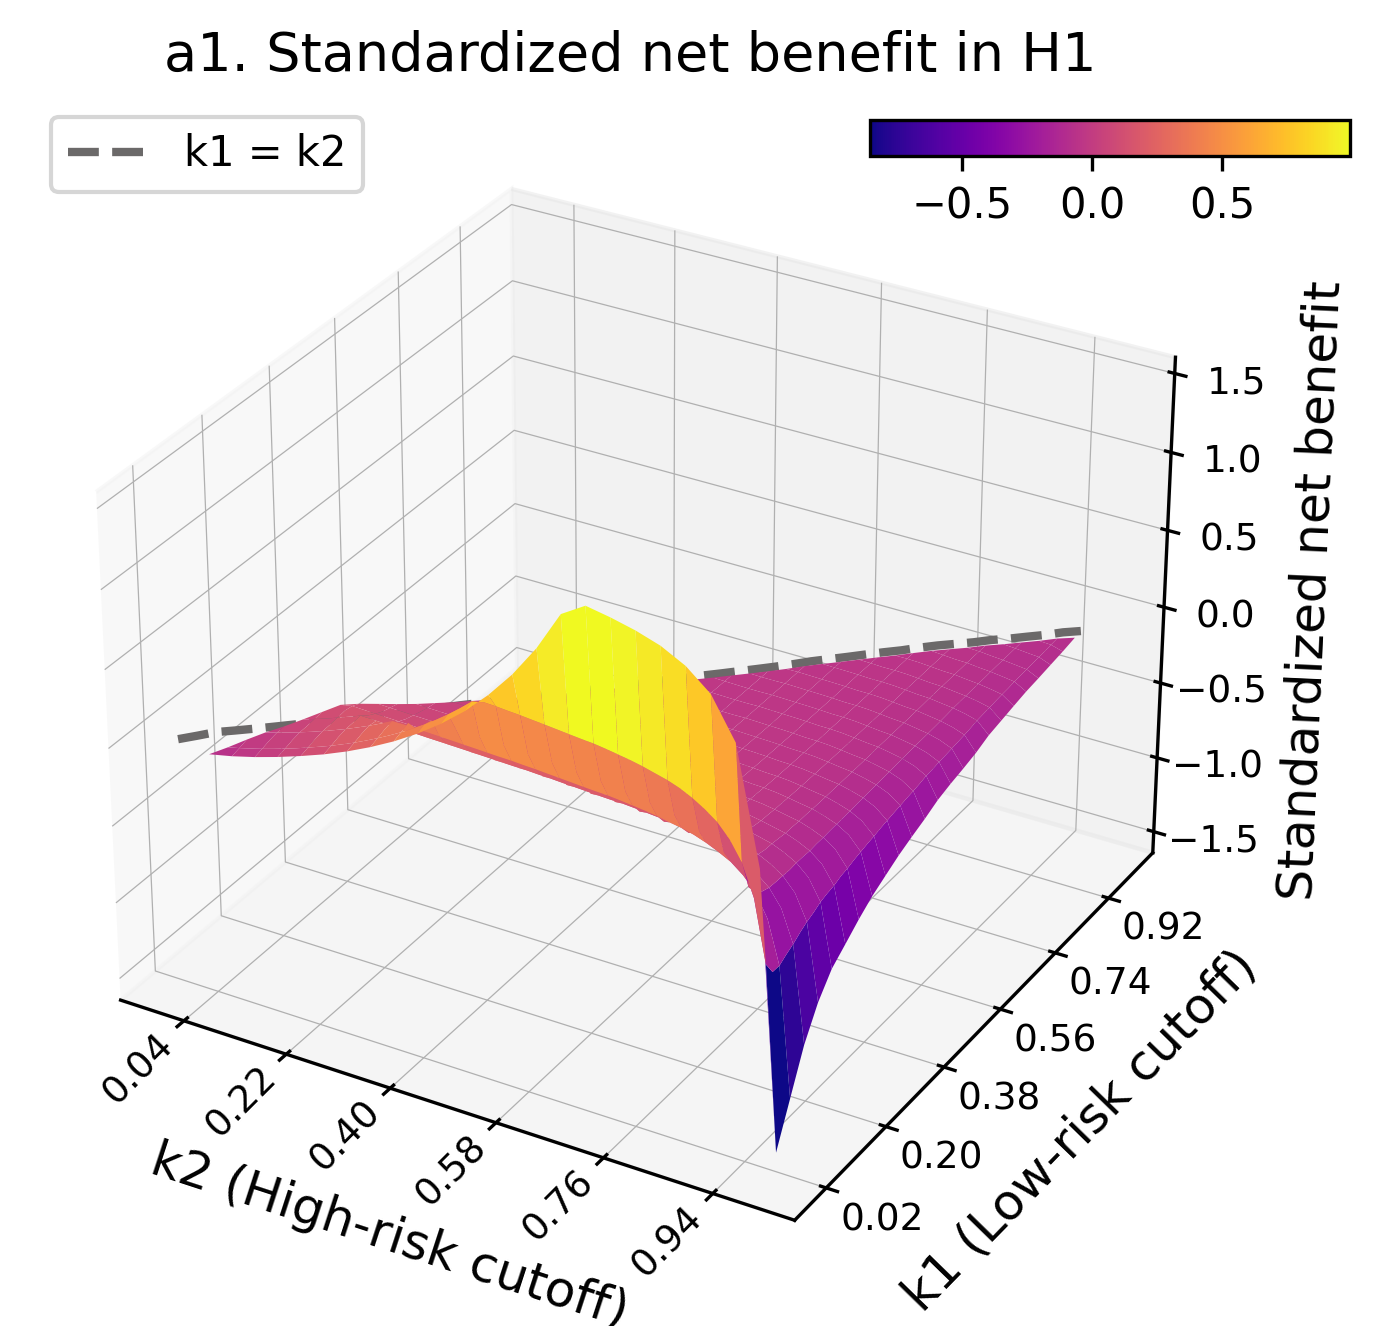

In [ ]:
############################ Plotting: 3D Surface ##########################
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

y = pred_result['y_test'].values  # True labels
p = pred_result['y_tepred'].values  # Model-predicted probabilities
N = len(pred_result)  # Sample size

# Parameter settings
B1 = 1.0
alpha = 0.6
beta = 0.1

# alpha = 0.8
# beta = 0.1

# Threshold grid
# k1_vals = np.concatenate([np.linspace(0.01, 0.25, 50), np.linspace(0.26, 0.90, 50),np.linspace(0.91, 1.0, 5)])  # Low-risk cutoff
# k2_vals = np.concatenate([np.linspace(0.01, 0.25, 50), np.linspace(0.26, 0.90, 50),np.linspace(0.91, 1.0, 5)])  # High-risk cutoff
k1_vals = np.arange(0, 1.01, 0.02)  # Low-risk cutoff
k2_vals = np.arange(0, 1.01, 0.02)  # High-risk cutoff
K1, K2 = np.meshgrid(k1_vals, k2_vals)

Z = np.full_like(K1, np.nan)  # Main surface
Z_diag_vals = []              # Values on the diagonal line (k1 = k2)
diag_k1, diag_k2 = [] , []    # Coordinates on the diagonal

# Compute surface values across threshold grid
for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        k1 = K1[i, j]
        k2 = K2[i, j]

        # if k1 < 0.05:
        #     Z[i, j] = np.nan
        #     continue

        # Invalid region: k1 > k2
        if k1 > k2:
            continue

        # === Binary classification case when k1 == k2 ===
        elif np.isclose(k1, k2, atol=1e-6):
            k = k1
            treat_mask = p >= k
            TP = np.sum((y == 1) & treat_mask)
            FP = np.sum((y == 0) & treat_mask)
            prevalence = np.mean(y)
            C = k / (1 - k)

            nb_model = (TP / N) - (FP / N) * C
            nb_all = prevalence - (1 - prevalence) * C
            nb_none = 0
            relative_nb = nb_model - max(nb_all, nb_none)

            Z[i, j] = np.nan  # Do not plot diagonal in the main surface
            diag_k1.append(k1)
            diag_k2.append(k2)
            Z_diag_vals.append(relative_nb)
            continue

        # === Three-level classification: standardized net benefit ===
        C1 = k2 / (1 - k2)
        L1 = (1 - k1) / k1
        C2 = beta * C1
        B2 = alpha * B1

        low_mask = p < k1
        mid_mask = (p >= k1) & (p <= k2)
        high_mask = p > k2

        net_benefit = 0
        net_benefit += np.sum((y == 1) & high_mask) * B1
        net_benefit += np.sum((y == 1) & mid_mask) * B2
        net_benefit -= np.sum((y == 1) & low_mask) * L1
        net_benefit -= np.sum((y == 0) & high_mask) * C1
        net_benefit -= np.sum((y == 0) & mid_mask) * C2
        net_benefit /= N

        prevalence = np.mean(y)
        nb_all = B1 * prevalence - C1 * (1 - prevalence)
        nb_none = -L1 * prevalence

        # Standardized relative net benefit
        Z[i, j] = net_benefit - max(nb_all, nb_none)

# === Plotting ===
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 1. Thin 3D grid lines
ax.xaxis._axinfo['grid'].update({'linewidth': 0.3})
ax.yaxis._axinfo['grid'].update({'linewidth': 0.3})
ax.zaxis._axinfo['grid'].update({'linewidth': 0.3})

# Main three-class net benefit surface (k1 < k2)
surf = ax.plot_surface(K2, K1, Z, cmap='plasma', edgecolor='none')

# Construct diagonal values (k1 = k2)
if len(diag_k1) > 0:
    diag_k1_arr = np.array(diag_k1)
    diag_k2_arr = np.array(diag_k2)
    Z_diag_arr = np.array(Z_diag_vals)

    # Diagonal dashed line
    ax.plot3D(diag_k2_arr, diag_k1_arr, Z_diag_arr,
              color="#6B6969", linewidth=2, linestyle='--', label='k1 = k2')
    ax.legend(loc='upper left', fontsize=10)

# Axis labels
ax.set_xlabel("k2 (High-risk cutoff)", fontsize=12, labelpad=1)
ax.set_ylabel("k1 (Low-risk cutoff)", fontsize=12, labelpad=1)
ax.set_zlabel("Standardized net benefit", fontsize=12, rotation=90, labelpad=1)

if db_name == 'H2':
    ax.set_title("a1. Standardized net benefit", fontsize=14)
elif db_name == 'H1':
    ax.set_title(f"a1. Standardized net benefit in {db_name}", fontsize=13)
elif db_name == 'H3':
    ax.set_title(f"b1. Standardized net benefit in {db_name}", fontsize=13)

# Add colorbar (shifted rightward)
cax = inset_axes(
    ax,
    width="40%", height="3%",
    loc='upper right',
    bbox_to_anchor=(0.1, -0.02, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)
cbar = fig.colorbar(surf, cax=cax, orientation='horizontal')
cbar.locator = MaxNLocator(nbins=4)
cbar.update_ticks()

# Collect all valid k1, k2, z
k1_list, k2_list, z_list = [], [], []
for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        if not np.isnan(Z[i, j]):
            k1_list.append(K1[i, j])
            k2_list.append(K2[i, j])
            z_list.append(Z[i, j])

df = pd.DataFrame({'k1': k1_list, 'k2': k2_list, 'z': z_list})
print(df)

# Set axis ticks based on actual sampled points
unique_k1 = np.unique(k1_list)
unique_k2 = np.unique(k2_list)
ax.set_xticks(unique_k2[::9])
ax.set_yticks(unique_k1[::9])

# Rotate tick labels
ax.set_xticklabels([f"{x:.2f}" for x in unique_k2[::9]], rotation=45, ha='right')
ax.set_yticklabels([f"{y:.2f}" for y in unique_k1[::9]], rotation=0, ha='left')

ax.tick_params(axis='x', labelsize=9, pad=-7)
ax.tick_params(axis='y', labelsize=9, pad=-5)
ax.tick_params(axis='z', labelsize=9, pad=1)

# Identify maximum Z value and its (k1, k2)
max_z = np.nanmax(Z)
max_idx = np.unravel_index(np.nanargmax(Z), Z.shape)
best_k1 = K1[max_idx]
best_k2 = K2[max_idx]

print('alpha:', alpha, 'beta:', beta)
print(f"Maximum standardized net benefit: {max_z:.4f}, at k1={best_k1:.3f}, k2={best_k2:.3f}")

# Query specific point
query_k1 = 0.10
query_k2 = 0.79
idx_k1 = (np.abs(k1_vals - query_k1)).argmin()
idx_k2 = (np.abs(k2_vals - query_k2)).argmin()
z_value = Z[idx_k2, idx_k1]  # Row = k2, Column = k1
print(f"For k1={query_k1:.3f}, k2={query_k2:.3f}, z = {z_value:.4f}")

# Adjust figure margins
fig.subplots_adjust(left=0.4, right=0.8, top=0.9, bottom=0.15)
plt.show()


       k1    k2         z
0    0.03  0.06 -0.074734
1    0.03  0.09 -0.047847
2    0.06  0.09 -0.019668
3    0.03  0.12 -0.017825
4    0.06  0.12  0.010846
..    ...   ...       ...
523  0.84  0.99 -0.172561
524  0.87  0.99 -0.156713
525  0.90  0.99 -0.134861
526  0.93  0.99 -0.112338
527  0.96  0.99 -0.086730

[528 rows x 3 columns]


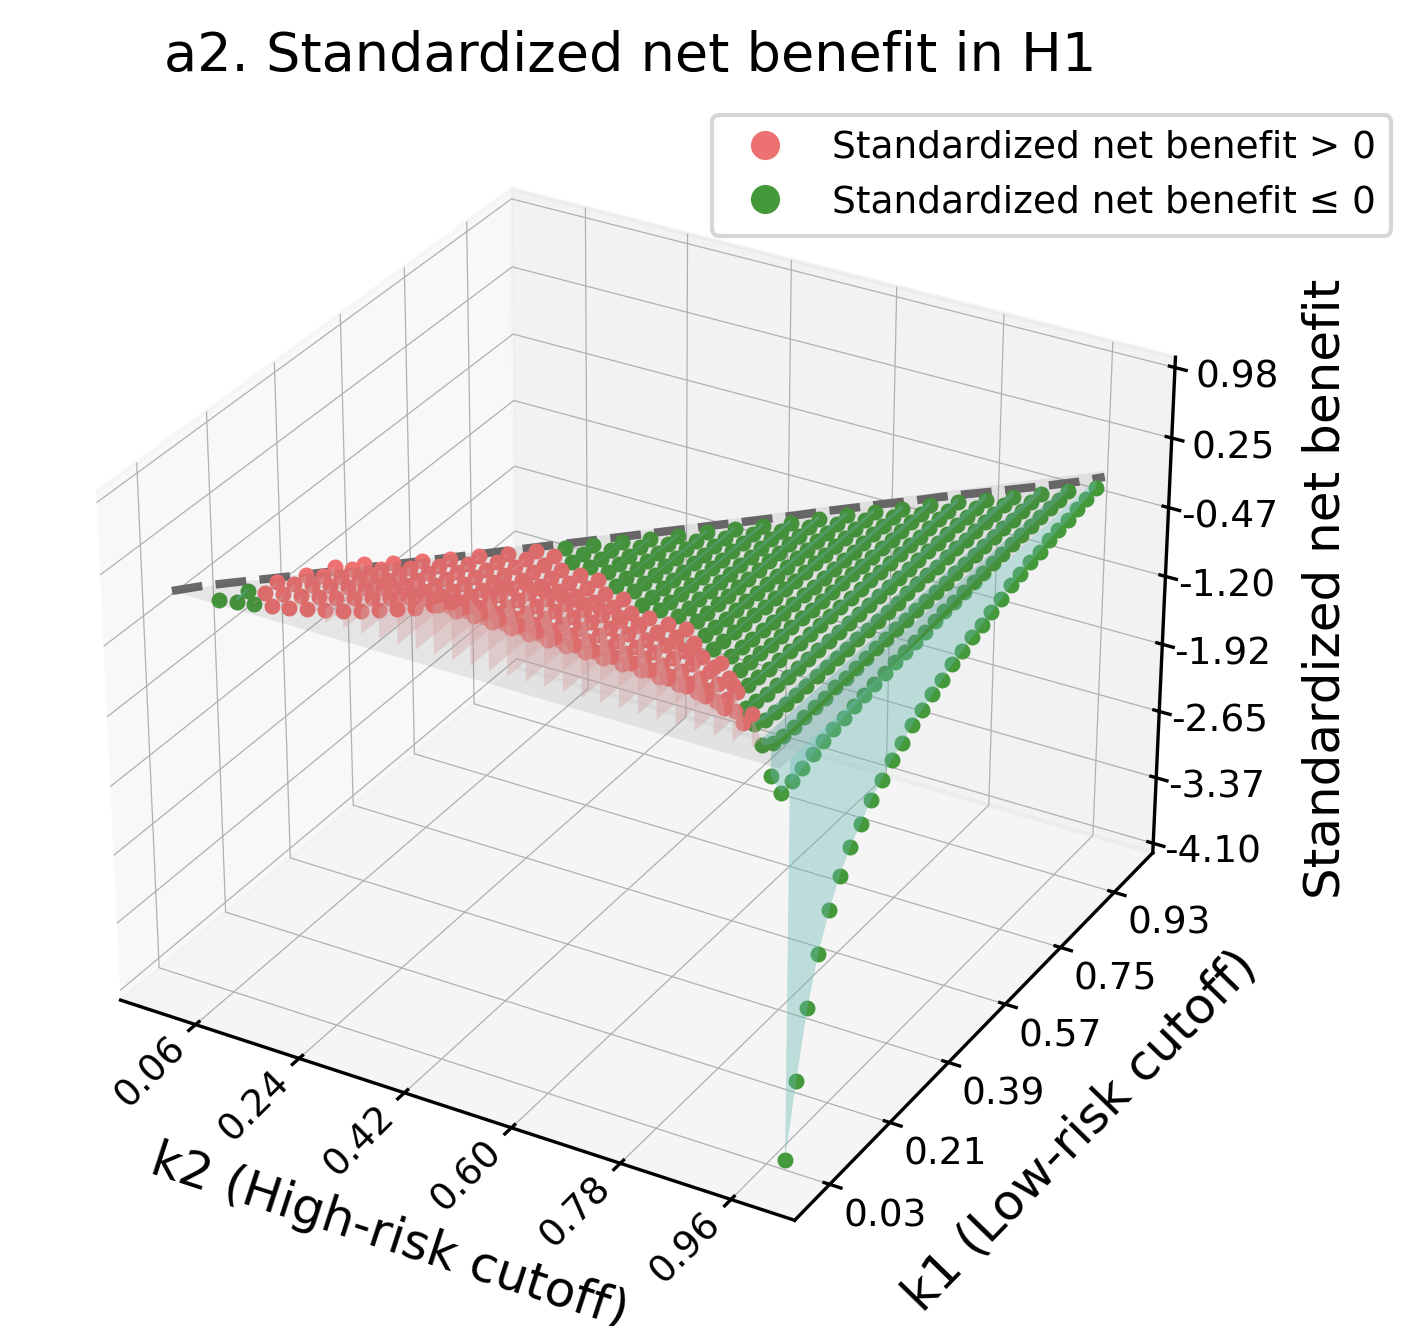

In [ ]:
########################### Plotting: 3D Scatter ###########################
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Assume pred_result is already defined
y = pred_result['y_test'].values
p = pred_result['y_tepred'].values
N = len(pred_result)

B1 = 1.0
alpha = 0.6
beta = 0.1
# alpha = 0.5
# beta = 0.2

# Threshold grids
# k1_vals = np.linspace(0.01, 0.25, 10)   # Low-risk threshold, number of groups
# k2_vals = np.linspace(0.26, 0.90, 10)   # High-risk threshold, number of groups

k1_vals = np.arange(0.0, 1.01, 0.03)  # Low-risk threshold, interval
k2_vals = np.arange(0.0, 1.01, 0.03)  # High-risk threshold, interval

K1, K2 = np.meshgrid(k1_vals, k2_vals)
# K2, K1 = np.meshgrid(k2_vals, k1_vals)

Z = np.full_like(K1, np.nan)  # Main surface
Z_diag_vals = []              # Diagonal values (k1 = k2)
diag_k1, diag_k2 = [], []     # Diagonal k1/k2 coordinates

# Loop through and compute
for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        k1 = K1[i, j]
        k2 = K2[i, j]

        # # Add this condition
        # if k1 < 0.05:
        #     Z[i, j] = np.nan
        #     continue

        if k1 > k2:
            continue
        elif np.isclose(k1, k2, atol=1e-6):
            # === Binary classification scenario ===
            k = k1
            treat_mask = p >= k
            TP = np.sum((y == 1) & treat_mask)
            FP = np.sum((y == 0) & treat_mask)
            prevalence = np.mean(y)
            C = k / (1 - k)

            nb_model = (TP / N) - (FP / N) * C
            nb_all = prevalence - (1 - prevalence) * C
            nb_none = 0
            relative_nb = nb_model - max(nb_all, nb_none)

            Z[i, j] = np.nan  # Do not plot diagonal on main surface
            diag_k1.append(k1)
            diag_k2.append(k2)
            Z_diag_vals.append(relative_nb)
            continue

        # === Three-class net benefit ===
        C1 = k2 / (1 - k2)
        L1 = (1 - k1) / k1
        C2 = beta * C1
        B2 = alpha * B1

        low_mask = p < k1
        mid_mask = (p >= k1) & (p <= k2)
        high_mask = p > k2

        net_benefit = 0
        net_benefit += np.sum((y == 1) & high_mask) * B1
        net_benefit += np.sum((y == 1) & mid_mask) * B2
        net_benefit -= np.sum((y == 1) & low_mask) * L1
        net_benefit -= np.sum((y == 0) & high_mask) * C1
        net_benefit -= np.sum((y == 0) & mid_mask) * C2
        net_benefit /= N

        prevalence = np.mean(y)
        nb_all = B1 * prevalence - C1 * (1 - prevalence)
        nb_none = -L1 * prevalence
        # Relative net benefit (increment)
        Z[i, j] = net_benefit - max(nb_all, nb_none)

# Collect all non-NaN k1, k2, z
k1_list = []
k2_list = []
z_list = []

for i in range(K1.shape[0]):
    for j in range(K1.shape[1]):
        if not np.isnan(Z[i, j]):
            k1_list.append(K1[i, j])
            k2_list.append(K2[i, j])
            z_list.append(Z[i, j])

df = pd.DataFrame({
    'k1': k1_list,
    'k2': k2_list,
    'z': z_list
})

print(df)
# df.to_excel('./relative_net_benefit.xlsx', index=False)

# Plot
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# 1. First draw the gray reference plane (bottom layer)
X, Y = np.meshgrid(k2_vals, k1_vals)
Z0 = np.zeros_like(X)

# # Add zero-benefit plane (light gray)
# zero_plane = np.zeros_like(K1)
# ax.plot_surface(X, Y, Z0, color="gray", alpha=0.1, linewidth=0, zorder=0)

# 1. Draw gray surface only in k1 <= k2 region
zero_plane_mask = K1 <= K2
zero_plane = np.zeros_like(K1)
zero_plane_masked = np.where(zero_plane_mask, zero_plane, np.nan)

# Draw gray plane (diagonal and below)
ax.plot_surface(K2, K1, zero_plane_masked, color="gray", alpha=0.1, linewidth=0, zorder=0)

# # 2. Optional contour to enhance visualization
# ax.contourf(K2, K1, Z, zdir='z', offset=0, cmap='RdYlGn', alpha=0.4, levels=20)

# # 3. Disable 3D grid lines
# ax.grid(False)

# 1. Thin grid lines to make the figure cleaner
ax.xaxis._axinfo['grid'].update({'linewidth': 0.3})
ax.yaxis._axinfo['grid'].update({'linewidth': 0.3})
ax.zaxis._axinfo['grid'].update({'linewidth': 0.3})

# 2. Then plot the scatter points (on top)
for i in range(Z.shape[0]):
    # Surface patch
    for j in range(Z.shape[1] - 1):
        if np.isnan(Z[i, j]) or np.isnan(Z[i, j + 1]):
            continue

        # Determine color
        if (Z[i, j] > 0) or (Z[i, j + 1] > 0):
            face_color = "#e6aeae"  # Light pink
        else:
            face_color = "#68b9b3"  # Light green

        # Construct a quad along the k1 direction
        verts = [
            [k2_vals[i], k1_vals[j], 0],
            [k2_vals[i], k1_vals[j + 1], 0],
            [k2_vals[i], k1_vals[j + 1], Z[i, j + 1]],
            [k2_vals[i], k1_vals[j], Z[i, j]]
        ]

        ax.add_collection3d(
            Poly3DCollection([verts], color=face_color, alpha=0.4, edgecolor='none')
        )

    for j in range(Z.shape[1]):
        if not np.isnan(Z[i, j]):
            color = "#EE7171" if Z[i, j] > 0 else "#44993b"
            ax.scatter(k2_vals[i], k1_vals[j], Z[i, j],
                       color=color, s=8, zorder=10)

# 3. Set view angle for better height contrast
# ax.view_init(elev=30, azim=-45)
# ax.view_init(elev=30, azim=-75)
# ax.view_init(elev=20, azim=120)

# 4. Ensure Z-axis covers all points
z_min = min(np.nanmin(z_list), 0)
z_max = max(np.nanmax(z_list), 0)
z_padding = (z_max - z_min) * 0.1
ax.set_zlim(z_min - z_padding, z_max + z_padding)

# Plot diagonal reference line k1 = k2
if len(diag_k1) > 0:
    diag_k1_arr = np.array(diag_k1)
    diag_k2_arr = np.array(diag_k2)
    Z_diag_arr = np.array(Z_diag_vals)

    ax.plot3D(diag_k2_arr, diag_k1_arr, Z_diag_arr,
              color="#6B6969", linewidth=2, linestyle='--', label='k1 = k2')
    ax.legend(loc='upper left', fontsize=10)

ax.set_xlabel('k2 (High-risk cutoff)', fontsize=12, labelpad=1)
ax.set_ylabel('k1 (Low-risk cutoff)', fontsize=12, labelpad=1)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Standardized net benefit', rotation=90, fontsize=12, labelpad=3)

if db_name == 'H2':
    ax.set_title("a2. Standardized net benefit", fontsize=14)
elif db_name == 'H1':
    ax.set_title(f"a2. Standardized net benefit in {db_name}", fontsize=13)
elif db_name == 'H3':
    ax.set_title(f"b2. Standardized net benefit in {db_name}", fontsize=13)

# Set axis ticks using actual scatter coordinates
unique_k1 = np.unique(k1_list)
unique_k2 = np.unique(k2_list)
ax.set_xticks(unique_k2[::6])
ax.set_yticks(unique_k1[::6])

# Rotate tick labels
ax.set_xticklabels([f"{x:.2f}" for x in unique_k2[::6]], rotation=45, ha='right')
ax.set_yticklabels([f"{y:.2f}" for y in unique_k1[::6]], rotation=0, ha='left')

# Auto-set Z-axis limits ensuring 0 is included
z_min = min(np.nanmin(z_list), 0)
z_max = max(np.nanmax(z_list), 0)
ax.set_zlim(z_min, z_max)

# Set Z-axis tick labels
unique_z = np.unique(np.round(z_list, 2))
unique_z = unique_z[~np.isnan(unique_z)]
if len(unique_z) > 8:
    sampled_z = np.linspace(unique_z.min(), unique_z.max(), 8)
else:
    sampled_z = unique_z
ax.set_zticks(sampled_z)
ax.set_zticklabels([f"{z:.2f}" for z in sampled_z], fontsize=9)

ax.tick_params(axis='x', labelsize=9, pad=-7)
ax.tick_params(axis='y', labelsize=9, pad=-5)
ax.tick_params(axis='z', labelsize=9, pad=1)

# Legend (using scatter markers instead of patches)
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label='Standardized net benefit > 0',
           markerfacecolor="#EE7171", markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label='Standardized net benefit ≤ 0',
           markerfacecolor="#44993b", markersize=8)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9,
          bbox_to_anchor=(1.15, 1))

fig.subplots_adjust(left=0.4, right=0.8, top=3, bottom=0.45)
plt.show()


## PPV and NPV change with the threshold

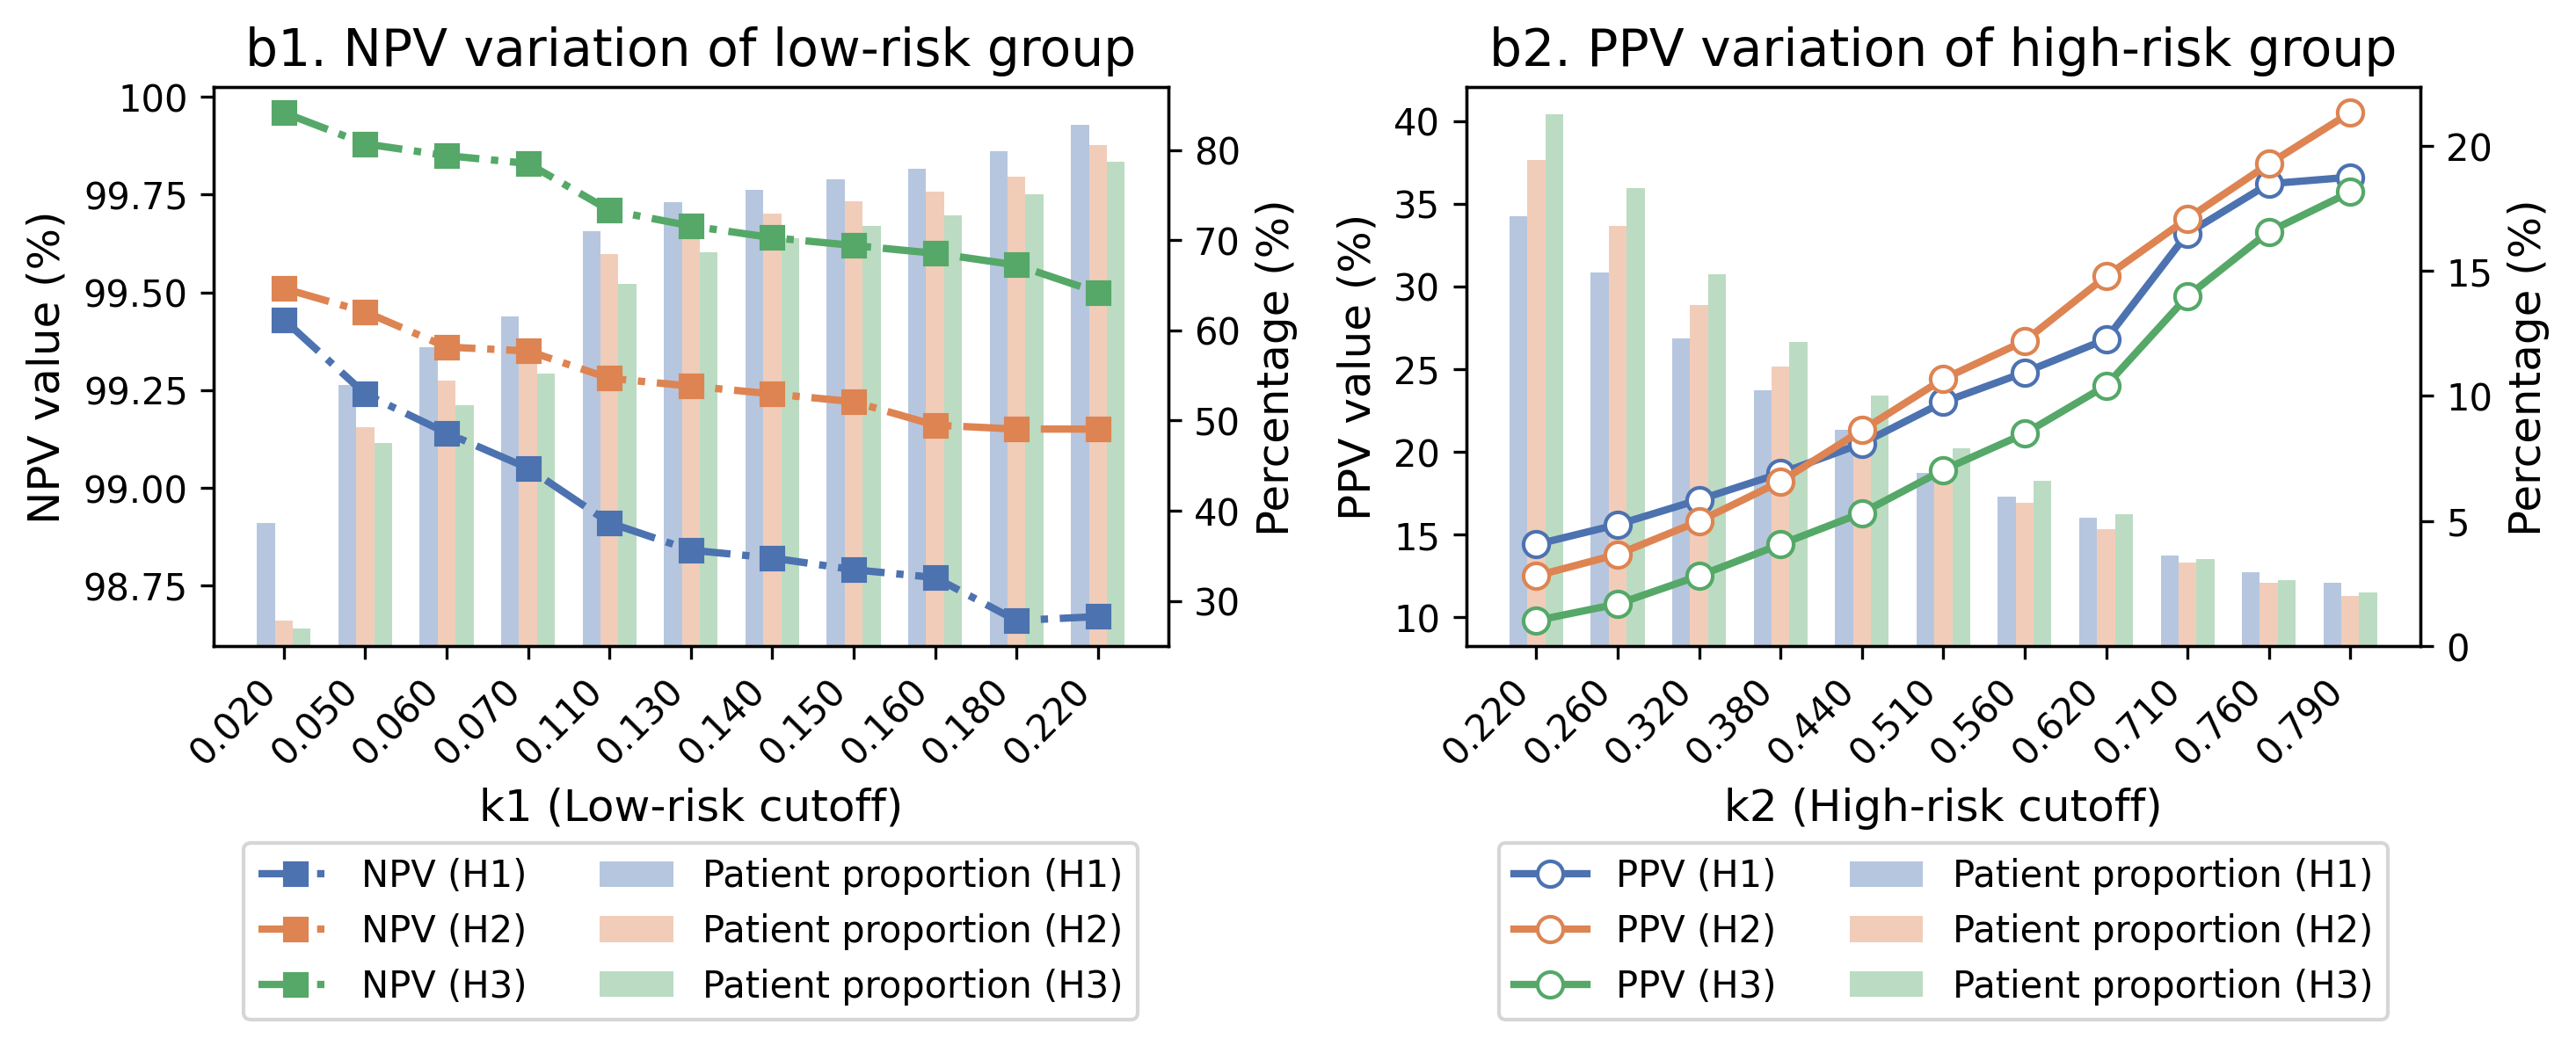

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


db_mapping = {
    'H1': {'db': 'GDPH', 'color': "#4C72B0"},  # Blue
    'H2': {'db': 'SZBA', 'color': "#DD8452"},  # Orange
    'H3': {'db': 'MIMIC', 'color': "#55A868"}  # Green
}

db_names = ['H1', 'H2', 'H3']

thr1_lst = ['0.020', '0.050', '0.060', '0.070', '0.110', '0.130', '0.140', '0.150', '0.160', '0.180','0.220']
thr2_lst = ['0.220', '0.260', '0.320', '0.380', '0.440', '0.510', '0.560', '0.620', '0.710', '0.760', '0.790']

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5), dpi=300)
axs0_3 = axs[0].twinx()
axs2_3 = axs[1].twinx()

bar_width = 0.22
bar_offsets = [-bar_width, 0, bar_width]  # Offset for the three centers

for idx, db_rename in enumerate(db_names):
    db = db_mapping[db_rename]['db']
    color = db_mapping[db_rename]['color']
    if db_rename == 'H2':
        cd = r'./7-SZBA_prospective/'
        search_path1 = cd + '7.6.2-risk_level_divide/' + db + '/' + 'change_thr1/'
        search_path2 = cd + '7.6.2-risk_level_divide/' + db + '/' + 'change_thr2/'
    else:
        cd = r'./'
        search_path1 = cd + '6.2-risk_level_divide/' + db + '/' + 'change_thr1/'
        search_path2 = cd + '6.2-risk_level_divide/' + db + '/' + 'change_thr2/'

    # Low-risk threshold
    df1_1 = pd.read_csv(search_path1 + 'index_level0.csv', dtype={'Thr': str})
    df1_1 = df1_1[df1_1['Thr'].isin(thr1_lst)]
    df1_1['Proportion'] = df1_1['Proportion'].apply(lambda x: x.split('%')[0])
    df1_1['Proportion'] = df1_1['Proportion'].astype(float)

    # High-risk threshold
    df2_3 = pd.read_csv(search_path2 + 'index_level2.csv', dtype={'Thr': str})
    df2_3 = df2_3[df2_3['Thr'].isin(thr2_lst)]
    df2_3['Proportion'] = df2_3['Proportion'].apply(lambda x: x.split('%')[0])
    df2_3['Proportion'] = df2_3['Proportion'].astype(float)

    # ----------- Left panel: NPV -----------
    x1 = df1_1['Thr'].astype(float).astype(str)
    y1 = np.round(df1_1['NPV'] * 100, 2)  # Multiply by 100 and keep 2 decimals
    ind1 = np.arange(len(x1))
    line1, = axs[0].plot(x1, y1, label=f'NPV ({db_rename})', marker='s',
                         linestyle='-.', lw=2, color=color, markersize=6)
    axs0_3.bar(ind1 + bar_offsets[idx], df1_1['Proportion'], bar_width,
               color=color, alpha=0.4, label=f'Patient proportion ({db_rename})')
    # line1.set_zorder(10)  # Bring the line plot to front

    # ----------- Right panel: PPV -----------
    x2 = df2_3['Thr'].astype(float).astype(str)
    y2 = np.round(df2_3['PPV'] * 100, 2)  # Multiply by 100 and keep 2 decimals
    ind2 = np.arange(len(x2))
    line2, = axs[1].plot(x2, y2, label=f'PPV ({db_rename})', marker='o',
                         linestyle='-', lw=2, color=color, markerfacecolor='white', markersize=7)
    axs2_3.bar(ind2 + bar_offsets[idx], df2_3['Proportion'], bar_width,
               color=color, alpha=0.4, label=f'Patient proportion ({db_rename})')
    # line2.set_zorder(10)  # Bring the line plot to front

# axs[0].set_xlabel('Thresholds (change low-risk cutoff)', fontsize=12)
axs[0].set_xlabel('k1 (Low-risk cutoff)', fontsize=12)
# axs[0].set_ylabel('NPV value', fontsize=10)
axs[0].set_ylabel('NPV value (%)', fontsize=12)
axs[0].set_title('b1. NPV variation of low-risk group', fontsize=14)
axs[0].set_xticks(np.arange(len(thr1_lst)))
axs[0].set_xticklabels(thr1_lst, rotation=45, ha='right')
axs0_3.set_ylabel('Percentage (%)', fontsize=12)
axs0_3.set_ylim(bottom=25)  # Start display from 25

# axs[1].set_xlabel('Thresholds (change high-risk cutoff)', fontsize=12)
axs[1].set_xlabel('k2 (High-risk cutoff)', fontsize=12)
# axs[1].set_ylabel('PPV value', fontsize=10)
axs[1].set_ylabel('PPV value (%)', fontsize=12)
axs[1].set_title('b2. PPV variation of high-risk group', fontsize=14)
axs[1].set_xticks(np.arange(len(thr2_lst)))
axs[1].set_xticklabels(thr2_lst, rotation=45, ha='right')
axs2_3.set_ylabel('Percentage (%)', fontsize=12)

# Merge legends
lines0, labels0 = axs[0].get_legend_handles_labels()
bars0, barlabels0 = axs0_3.get_legend_handles_labels()
axs[0].legend(lines0 + bars0, labels0 + barlabels0,
              loc='upper center', bbox_to_anchor=(0.5, -0.32), ncol=2, fontsize=10)

lines1, labels1 = axs[1].get_legend_handles_labels()
bars1, barlabels1 = axs2_3.get_legend_handles_labels()
axs[1].legend(lines1 + bars1, labels1 + barlabels1,
              loc='upper center', bbox_to_anchor=(0.5, -0.32), ncol=2, fontsize=10)

axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)
axs0_3.tick_params(axis='y', labelsize=10)

axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)
axs2_3.tick_params(axis='y', labelsize=10)

def y_formatter(x, pos):
    if np.isclose(x, 100):
        return '100'
    else:
        return f'{x:.2f}'

axs[0].yaxis.set_major_formatter(FuncFormatter(y_formatter))

# Set primary axis above secondary axis
axs0_3.set_zorder(0)
axs[0].set_zorder(1)
axs[0].patch.set_visible(False)

axs2_3.set_zorder(0)
axs[1].set_zorder(1)
axs[1].patch.set_visible(False)

plt.subplots_adjust(wspace=0.28)
plt.tight_layout()
plt.show()
plt.close()
